### Build tSNE Projections of a Few DUD-E Datasets

In [2]:
import pandas as pd
import useful_rdkit_utils as uru
from rdkit.rdBase import BlockLogs
from tqdm.auto import tqdm
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [3]:
tqdm.pandas()

A function to read a DUD-E dataset, calculate fingerprints and project the fingerprints into two dimensions with tSNE.

In [5]:
def read_data(dirname):
    active_df = pd.read_csv(f"{dirname}/actives_final.ism",sep=" ",names=["SMILES","Cmpd_ID","ChEMBL_ID"])
    active_df['active'] = 1
    decoy_df = pd.read_csv(f"{dirname}/decoys_final.ism",sep=" ",names=["SMILES","Cmpd_ID","ChEMBL_ID"])
    decoy_df['active'] = 0
    combo_df = pd.concat([active_df, decoy_df]).reset_index()
    smi2fp = uru.Smi2Fp()
    combo_df['fp'] = combo_df.SMILES.progress_apply(smi2fp.get_fp)
    combo_df.dropna(subset="fp",inplace=True)
    pca = PCA(n_components=50)
    pcs = pca.fit_transform(np.stack(combo_df.fp))
    tsne = TSNE(n_components=2)
    tsne_res = tsne.fit_transform(pcs)
    combo_df['tsne_x'] = tsne_res[:,0]
    combo_df['tsne_y'] = tsne_res[:,1]    
    return combo_df

Read the DUD-E summary data

In [6]:
target_df = pd.read_csv("dud-e.target_class.csv")
sample_df = target_df.drop_duplicates("Target Class")

Read the a few datasets and do the tSNE calcuations.

In [7]:
df_list = []
for target in tqdm(sample_df["Target Name"]):
    dirname = f"/Users/pwalters/DATA/DUD-E/all/{target}"
    row_df = read_data(dirname)
    row_df['target'] = target
    df_list.append(row_df)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/32032 [00:00<?, ?it/s]

  0%|          | 0/16743 [00:00<?, ?it/s]

  0%|          | 0/31664 [00:00<?, ?it/s]

  0%|          | 0/28862 [00:00<?, ?it/s]

  0%|          | 0/15258 [00:00<?, ?it/s]

[09:31:52] Explicit valence for atom # 9 N, 5, is greater than permitted


  0%|          | 0/12003 [00:00<?, ?it/s]

  0%|          | 0/7570 [00:00<?, ?it/s]

Make the tSNE plots

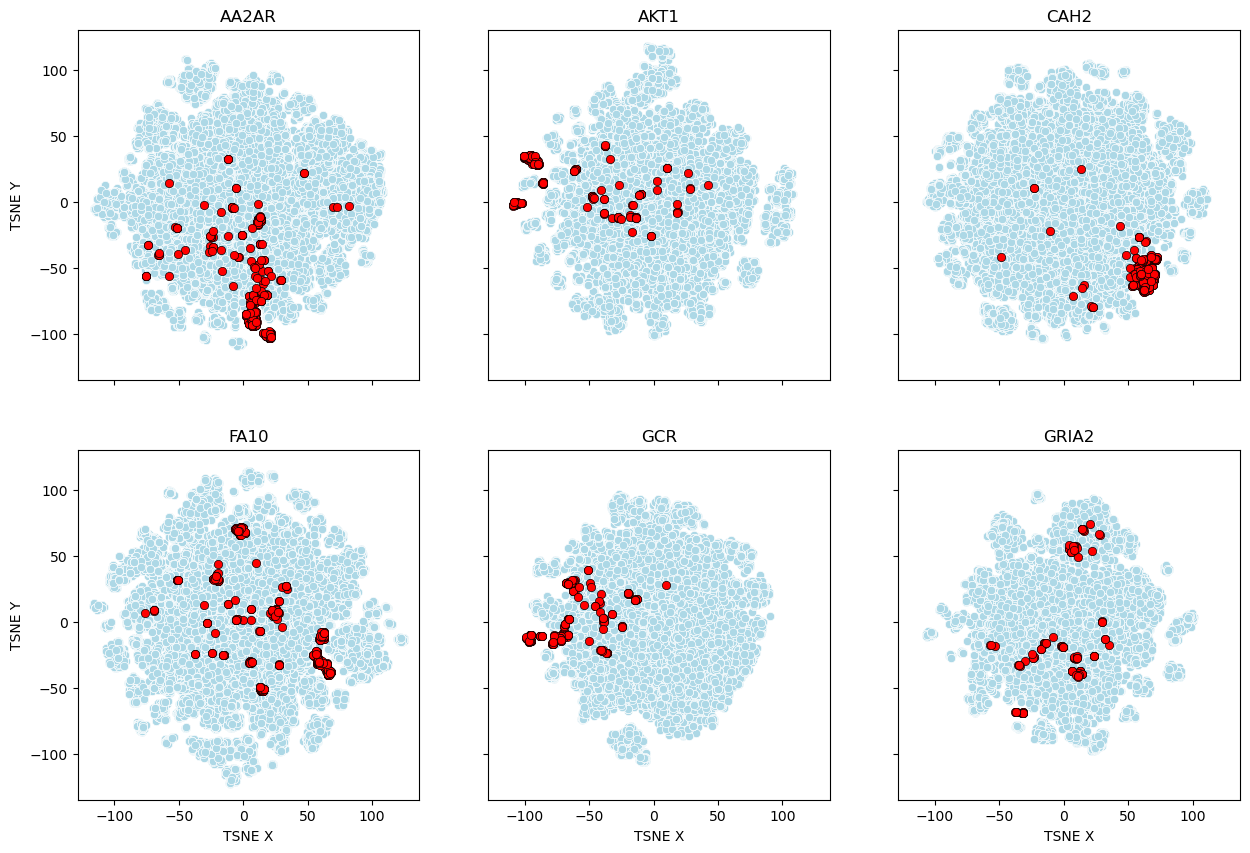

In [6]:
figure, axes = plt.subplots(2,3,figsize=(15,10),sharex=True,sharey=True)
axes = axes.flatten()
for idx,df in enumerate(df_list[:6]):
    sns.scatterplot(x="tsne_x",y="tsne_y",color="lightblue",data=df.query("active == 0"),ax=axes[idx])
    ax = sns.scatterplot(x="tsne_x",y="tsne_y",color="red",edgecolor="black",data=df.query("active == 1"),ax=axes[idx])
    ax.set_title(df.target.values[0].upper())
    ax.set_xlabel("TSNE X")
    ax.set_ylabel("TSNE Y")